In [19]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import seaborn as sns
import plotly.express as px
import json
from sklearn.model_selection import train_test_split


In [2]:
# Get raw, windowed data
import os
import urllib.request

if not os.path.exists('./data/raw/smoking_input.csv') or not os.path.exists('./data/raw/smoking_targets.csv'):
    os.system('mkdir -p data/raw')
    urllib.request.urlretrieve("http://ifestos.cse.sc.edu/datasets/smoking_data.tar.gz", "data/smoking_data.tar.gz")

    os.system('tar -xzvf data/smoking_data.tar.gz -C data/raw/ --strip-components=1')

smoking_data/smoking_input.csv
smoking_data/smoking_targets.csv


In [3]:
# Load data
X = pd.read_csv('data/raw/smoking_input.csv', header=None)
y = pd.read_csv('data/raw/smoking_targets.csv', header=None)

In [19]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# Formatting & Preprocessing

y.columns = ["label"]

# Fill NaNs
X = X.fillna(method='bfill')

# Put in torch tensors
X_pt = torch.from_numpy(X.to_numpy()).float().to(device)
y_pt = torch.from_numpy(y.to_numpy()).float().to(device)

# train-test split


(X_train, X_test, y_train, y_test) = train_test_split(X_pt, y_pt, test_size=0.2)

# Neural network

## Pytorch Model
- input layer 300 -> 10
- activation function ReLU
- hidden layer 10 -> 1
- output function Tanh

In [60]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(300, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits  


In [39]:
model = MLP().to(device)

### Train Model

In [30]:
def train(model, epochs, batch_size, loss_fn, optimizer, X_train, X_test, y_train, y_test):
    losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    model.train()
    for i in range(epochs):
        for j in range(0, len(X_train), batch_size):
            end = j+batch_size if j+batch_size < len(X_train) else len(X_train)

            # Forward pass
            logits = model(X_train[j:end])
            loss = loss_fn(logits, y_train[j:end])

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses[i] += loss

        losses[i] /= batch_size # get mean loss of all batches this epoch

        test_logits = model(X_test)
        test_loss = loss_fn(test_logits, y_test)
        test_losses[i] = test_loss

        if i%10 == 0:
            print(f"Epoch {i}: ", end='')
            print(f'\tLoss={loss.item()}', end='')
            print(f'\tTest Loss={test_loss.item()}')

    return (losses, test_losses)

### Test Model

In [10]:
model.eval()
with torch.no_grad():
    logits = model(X_test)

    loss = loss_fn(logits, y_test)

    pred = torch.round(nn.Sigmoid()(logits))
    accuracy = (sum(y_test == pred) / len(y_test)).item()

print(f'Test Loss: {loss:.4}')
print(f'Accuracy: {100*accuracy:.4}%')

Test Loss: 0.01104
Accuracy: 99.76%


In [50]:
# Save model

os.system('mkdir model')
torch.save(model.state_dict(), 'model/model.pt')

# Test on Continous Signal

In [3]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
file_index = 16

In [5]:
# Features

raw = pd.read_csv(f'data/{file_index}/raw_data.csv', header=None)

# Window Data
df = raw[[2,3,4]]

X = np.empty((len(df)-99, 300), dtype=float)
for i in range(len(df)-99):
    X[i] = df[i:i+100].to_numpy().T.flatten()

In [6]:
# Labels
annot = {}
y = np.zeros((len(X)))


with open(f'data/{file_index}/16_data.json') as f:
    annot = json.load(f)

for i in range(annot['start'], annot['end']):
    for puff in annot['puffs']:
        if i >= puff['start'] and i <= puff['end'] - 99:
            y[i] = 1

In [13]:
# visualize true labels

df['labels'] = np.pad(y*10, (0,99), mode='constant', constant_values=5)

fig = px.line(data_frame=df.loc[::10,[2, "labels"]])
fig.show(renderer='browser')

/tmp/ipykernel_2069270/1490788147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = np.pad(y*10, (0,99), mode='constant', constant_values=5)


Opening in existing browser session.


Gtk-Message: 16:59:29.738: Failed to load module "xapp-gtk3-module"
Gtk-Message: 16:59:29.738: Failed to load module "appmenu-gtk-module"


In [21]:
# Predict labels

X_pt = torch.from_numpy(X).float().to(device)
y_pt = torch.from_numpy(y).reshape(-1,1).float().to(device)

model = MLP().to(device)
model.load_state_dict(torch.load('model/model.pt'))
model.eval()

step = 10000    # for memory
preds = []
correct = 0
for i in range(0, len(X_pt), step):
    end = i+step if i+step < len(X_pt) else len(X_pt)
    with torch.no_grad():
        logits = model(X_pt[i:end])
        pred = torch.round(nn.Sigmoid()(logits))
        correct += sum(y_pt[i:end] == pred)
        preds += pred.flatten().tolist()

preds = np.array(preds)
accuracy = (correct / len(y_pt)).item()
print(f'Accuracy: {100*accuracy:.4}%')  # falsely high bc of all the true negatives

Accuracy: 96.13%


In [10]:
# Calculate accuracy based on just the smoking session windows
X_smoking = X[annot['start']:annot['end']]
preds_smoking = preds[annot['start']:annot['end']]

acc_smoking = sum(preds_smoking == y[annot['start']:annot['end']]) / len(preds_smoking)

print(f'Accuracy in Smoking Session: {100*acc_smoking:.4}%')  # still high bc of the true negatives

Accuracy in Smoking Session: 73.51%


In [11]:
# Accuracy by true positives

tps = 0
for i in range(len(y)):
    tps += (y[i] and preds[i])  # add one if both are 1

# acc_tp = len(np.where(preds==1)[0]) / len(np.where(y==1)[0])
acc_tp = tps / len(np.where(y==1)[0])
print(f'Percent of positives predicted: {100*acc_tp:.4}%')  # oof

Percent of positives predicted: 0.2674%


In [78]:
# Visualize predictions

df['preds'] = np.pad(preds*10, (0, 99), mode='constant', constant_values=0)

figure = px.line(df.loc[::10, [2, 'labels', 'preds']])
figure.show(renderer='browser')

/tmp/ipykernel_2069270/2576325511.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Opening in existing browser session.


Gtk-Message: 17:39:16.766: Failed to load module "xapp-gtk3-module"
Gtk-Message: 17:39:16.766: Failed to load module "appmenu-gtk-module"


In [61]:
# Train model

model = MLP().to(device)

(X_train, X_test, y_train, y_test) = train_test_split(X_pt[annot['start']:annot['end']], y_pt[annot['start']:annot['end']], test_size=0.25, stratify=y_pt[annot['start']:annot['end']].to('cpu'))

# Loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
batch_size = 128

(losses, test_losses) = train(model, epochs, batch_size, loss_fn, optimizer, X_train, X_test, y_train, y_test)

figure = px.line(pd.DataFrame({"loss": losses, "validation loss":test_losses}))
figure.show(renderer='browser')

Epoch 0: 	Loss=0.16119280457496643	Test Loss=0.12817129492759705
Epoch 10: 	Loss=0.12037324160337448	Test Loss=0.05572707951068878
Epoch 20: 	Loss=0.07652546465396881	Test Loss=0.05539275333285332
Epoch 30: 	Loss=0.05702270567417145	Test Loss=0.05460852384567261
Epoch 40: 	Loss=0.05092347413301468	Test Loss=0.05482245609164238
Epoch 50: 	Loss=0.046775057911872864	Test Loss=0.05532114580273628
Epoch 60: 	Loss=0.04248373955488205	Test Loss=0.05540613457560539
Epoch 70: 	Loss=0.03857682645320892	Test Loss=0.05524738132953644
Epoch 80: 	Loss=0.03610120713710785	Test Loss=0.055296171456575394
Epoch 90: 	Loss=0.03445607051253319	Test Loss=0.05581223592162132
Opening in existing browser session.


Gtk-Message: 17:32:16.566: Failed to load module "xapp-gtk3-module"
Gtk-Message: 17:32:16.566: Failed to load module "appmenu-gtk-module"


<Axes: >

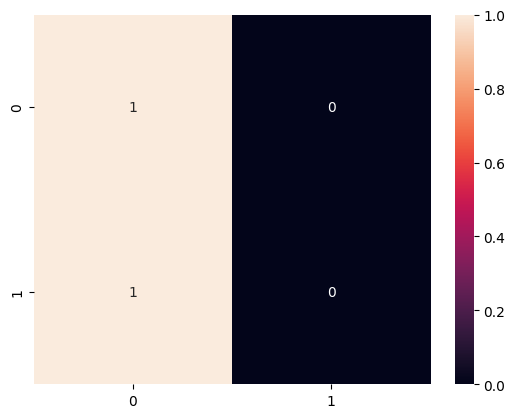

In [71]:
logits = model(X_test)
pred = nn.Sigmoid()(logits).argmax(axis=1)


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.detach().to('cpu'), pred.detach().to('cpu'), normalize="true")
sns.heatmap(cm, annot=True)

In [77]:
len(np.where(y_train.to('cpu')==1)[0])

3646